# Project : United States Immigration Data 



<img align="left" src="i94data.jpg" width="700" height="150">

In [ ]:
### The project follows the steps below:

* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [ ]:
### Scope

This project explores United States immigration data with the intentent of analyzing the following aspects:
- <i>Correlation between travel volumes and the entry ports</i>     
- <i>Correlation between travel volumes and the variation of dempographics in different cities</i>
- <i>The seasonality componente of travelling
- <i>The impact of temperatures on travellers' volume</i>


In [ ]:
### Data Sets

* **I94 Immigration Data**: This data comes from the US National Tourism and Trade Office and includes the contents of the i94 form on entry to the united states. A data dictionary is included in the workspace.
* **countries.csv** : Country codes extracted from the data dictionary
* **i94portCodes.csv**: City codes used extracted from the data dictionary

* **World Temperature Data**: This data set comes from Kaggle, and includes temperatures from several cities worldwide from 1743 to 2013.
* **U.S. City Demographic Data**: This data set comes from OpenSoft, and includes US cities demographics from the US Census Bureau's 2015 American Community Survey.
* **Airport Code Table**: Airport codes and corresponding cities.

### Importing libraries

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, date_add
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Immigration dataset

For this project we will be using the immigration data set which is comprised of three millions rows. However, to have a quick look at the data, we will be loading a subset (immigration_data_sample.csv)

In [2]:
# Read in the data here
immigration_df = pd.read_csv('immigration_data_sample.csv')

In [3]:
print(f'The sample data set is composed of {immigration_df.shape[0]} rows and {immigration_df.shape[1]} columns')

The sample data set is composed of 1000 rows and 29 columns


In [4]:
pd.options.display.width = 0
immigration_df.head(3).style.hide_index()

Unnamed: 0,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
2027561,4.08432e+06,2016,4,209,209,HHW,20566,1,HI,20573,61,2,1,20160422,nan,nan,G,O,nan,M,1955,07202016,F,nan,JL,5.65827e+10,00782,WT
2171295,4.42264e+06,2016,4,582,582,MCA,20567,1,TX,20568,26,2,1,20160423,MTR,nan,G,R,nan,M,1990,10222016,M,nan,*GA,9.4362e+10,XBLNG,B2
589494,1.1956e+06,2016,4,148,112,OGG,20551,1,FL,20571,76,2,1,20160407,nan,nan,G,O,nan,M,1940,07052016,M,nan,LH,5.57805e+10,00464,WT


In [5]:
columns_names = immigration_df.columns
pd.DataFrame(columns_names, columns=['Column_Names']).style.hide_index()

Column_Names
Unnamed: 0
cicid
i94yr
i94mon
i94cit
i94res
i94port
arrdate
i94mode
i94addr


<nobr><i> Immigration dataframe fields description can be found in the file <b>I94_SAS_Lables_Description.SAS</b></i>

#### Mapping I94CIT & I94RES to Countries

In [6]:
country_codes_df = pd.read_csv('countries.csv')
display(country_codes_df.head(10).style.hide_index())

code,country
582,MEXICO
236,AFGHANISTAN
101,ALBANIA
316,ALGERIA
102,ANDORRA
324,ANGOLA
529,ANGUILLA
518,ANTIGUA-BARBUDA
687,ARGENTINA
151,ARMENIA


#### Mapping  I94PORT to location, state

In [7]:
i94_port_df =pd.read_csv('i94ports_coding.csv')
i94_port_df.head().style.hide_index()

code,location,state
ALC,ALCAN,AK
ANC,ANCHORAGE,AK
BAR,BAKER AAF - BAKER ISLAND,AK
DAC,DALTONS CACHE,AK
PIZ,DEW STATION PT LAY DEW,AK


#### Demographic Data

In [8]:
demographic_df = pd.read_csv('us-cities-demographics.csv',delimiter=';')
demographic_df.head().style.hide_index()

City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
Quincy,Massachusetts,41,44129,49500,93629,4147,32935,2.39,MA,White,58723
Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


In [9]:
print(f'The demographic data set contains {demographic_df.shape[0]} rows and {demographic_df.shape[1]} columns')

The demographic data set contains 2891 rows and 12 columns


In [10]:
pd.DataFrame(demographic_df.columns, columns=['Column_Names']).style.hide_index()

Column_Names
City
State
Median Age
Male Population
Female Population
Total Population
Number of Veterans
Foreign-born
Average Household Size
State Code


#### Airport data

In [11]:
airport_df = pd.read_csv('airport-codes_csv.csv')
airport_df.head(3).style.hide_index()


ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
00A,heliport,Total Rf Heliport,11,nan,US,US-PA,Bensalem,00A,nan,00A,"-74.93360137939453, 40.07080078125"
00AA,small_airport,Aero B Ranch Airport,3435,nan,US,US-KS,Leoti,00AA,nan,00AA,"-101.473911, 38.704022"
00AK,small_airport,Lowell Field,450,nan,US,US-AK,Anchor Point,00AK,nan,00AK,"-151.695999146, 59.94919968"


In [12]:
print(f'The airport data set contains {airport_df.shape[0]} rows and {airport_df.shape[1]} columns')

The airport data set contains 55075 rows and 12 columns


In [13]:
pd.DataFrame(airport_df.columns, columns=['Column_Names']).style.hide_index()

Column_Names
ident
type
name
elevation_ft
continent
iso_country
iso_region
municipality
gps_code
iata_code


#### World Temperature Data

In [14]:

fname = '../../data2/GlobalLandTemperaturesByCity.csv'
temperature_df = pd.read_csv(fname)
temperature_df.head().style.hide_index()

dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E
1743-12-01,nan,nan,Århus,Denmark,57.05N,10.33E
1744-01-01,nan,nan,Århus,Denmark,57.05N,10.33E
1744-02-01,nan,nan,Århus,Denmark,57.05N,10.33E
1744-03-01,nan,nan,Århus,Denmark,57.05N,10.33E


In [15]:
print(f'The temperature data set contains {temperature_df.shape[0]} rows and {temperature_df.shape[1]} columns')

The temperature data set contains 8599212 rows and 7 columns


In [15]:
pd.DataFrame(temperature_df.columns, columns=['Column_Names']).style.hide_index()

Column_Names
dt
AverageTemperature
AverageTemperatureUncertainty
City
Country
Latitude
Longitude


#### Full Immigration data set

In [16]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.\
config("spark.jars.packages","saurfang:spark-sas7bdat:2.0.0-s_2.11")\
.enableHiveSupport().getOrCreate()
df_spark =spark.read.format('com.github.saurfang.sas.spark').load('../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat')


In [18]:
print(f'The Full Immigration Dataset has {df_spark.count()} rows and {len(df_spark.columns)} columns')

The Full Immigration Dataset has 3096313 rows and 28 columns


In [17]:
df_spark.printSchema()

root
 |-- cicid: double (nullable = true)
 |-- i94yr: double (nullable = true)
 |-- i94mon: double (nullable = true)
 |-- i94cit: double (nullable = true)
 |-- i94res: double (nullable = true)
 |-- i94port: string (nullable = true)
 |-- arrdate: double (nullable = true)
 |-- i94mode: double (nullable = true)
 |-- i94addr: string (nullable = true)
 |-- depdate: double (nullable = true)
 |-- i94bir: double (nullable = true)
 |-- i94visa: double (nullable = true)
 |-- count: double (nullable = true)
 |-- dtadfile: string (nullable = true)
 |-- visapost: string (nullable = true)
 |-- occup: string (nullable = true)
 |-- entdepa: string (nullable = true)
 |-- entdepd: string (nullable = true)
 |-- entdepu: string (nullable = true)
 |-- matflag: string (nullable = true)
 |-- biryear: double (nullable = true)
 |-- dtaddto: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- insnum: string (nullable = true)
 |-- airline: string (nullable = true)
 |-- admnum: double (nullable = 

In [ ]:
#write to parquet
df_spark.write.parquet("sas_data")
df_spark=spark.read.parquet("sas_data")

### Step 2: Explore and Assess the Data

#### Temperature Dataset

In [19]:
print(f'The temperature data set contains {temperature_df.shape[0]} rows and {temperature_df.shape[1]} columns')





The temperature data set contains 8599212 rows and 7 columns


In [20]:
temperature_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8599212 entries, 0 to 8599211
Data columns (total 7 columns):
dt                               object
AverageTemperature               float64
AverageTemperatureUncertainty    float64
City                             object
Country                          object
Latitude                         object
Longitude                        object
dtypes: float64(2), object(5)
memory usage: 459.2+ MB


<i>The <b>dt</b> column will need to be converted from string to datetime.</i>

In [21]:
temperature_df['convertedDate'] = pd.to_datetime(temperature_df.dt)

In [22]:
temperature_df.head(3)

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,convertedDate
0,1743-11-01,6.068,1.737,Århus,Denmark,57.05N,10.33E,1743-11-01
1,1743-12-01,NaN,NaN,Århus,Denmark,57.05N,10.33E,1743-12-01
2,1744-01-01,NaN,NaN,Århus,Denmark,57.05N,10.33E,1744-01-01


In [23]:
temperature_df.convertedDate.describe()

count                 8599212
unique                   3239
top       1939-11-01 00:00:00
freq                     3510
first     1743-11-01 00:00:00
last      2013-09-01 00:00:00
Name: convertedDate, dtype: object

In [24]:
print(f' The temperature dataframe includes data for {len(temperature_df.Country.unique())} countries; however, we will be only analyzing a substet of the data which only inlcudes the United States')

 The temperature dataframe includes data for 159 countries; however, we will be only analyzing a substet of the data which only inlcudes the United States


In [25]:
print(f'In addition we can see that the earliest date in the dataframe is {temperature_df.convertedDate.describe()[4]} which is before air travel even developed; therefore we can subset temperature_df further more')

In addition we can see that the earliest date in the dataframe is 1743-11-01 00:00:00 which is before air travel even developed; therefore we can subset temperature_df further more


In [26]:
temperature_df= temperature_df[(temperature_df['convertedDate']>"1950-01-01") &(temperature_df['Country']=='United States')]

In [27]:
print(f'The temperature data set contains {temperature_df.shape[0]} rows and {temperature_df.shape[1]} columns')


The temperature data set contains 196348 rows and 8 columns


In [28]:
temperature_df.convertedDate.describe()

count                  196348
unique                    764
top       1964-12-01 00:00:00
freq                      257
first     1950-02-01 00:00:00
last      2013-09-01 00:00:00
Name: convertedDate, dtype: object

<i> Max date in timeframe_df is <b>2013-09-01</b>,thus it will not possible to join timeframe_df with immigration data.</i>

#### Checking for missing data

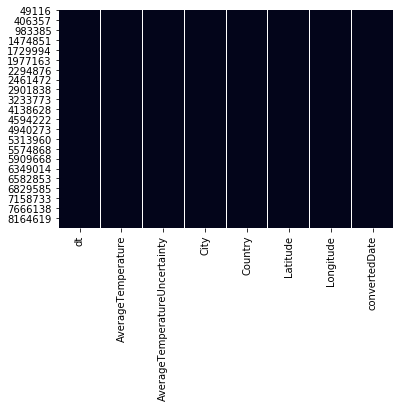

In [30]:
sns.heatmap(temperature_df.isnull(), cbar=False)

In [31]:
temperature_df.isnull().any()


dt                               False
AverageTemperature                True
AverageTemperatureUncertainty     True
City                             False
Country                          False
Latitude                         False
Longitude                        False
convertedDate                    False
dtype: bool

In [32]:
temperature_df.loc[temperature_df.AverageTemperatureUncertainty .isnull()]

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude,convertedDate
287781,2013-09-01,NaN,NaN,Anchorage,United States,61.88N,151.13W,2013-09-01


Null values will not be addressed since temperature_df is not going to be joined immigration data.

In [33]:
temperature_df.groupby('City')['AverageTemperature'].describe().head(3)

,count,mean,std,min,25%,50%,75%,max
City,,,,,,,,
Abilene,764.0,17.292291,8.222154,0.225,9.81025,17.5615,25.03475,32.110
Akron,764.0,10.199669,9.211566,-11.416,1.77275,10.3440,19.22900,24.966
Albuquerque,764.0,11.454635,8.263940,-2.729,4.03425,11.2815,19.58775,25.688


Since each city temperature is recorded multiple times, when creating the dimension table the composite primary key will have to be city and average temperature.


#### Airport Dataset

In [34]:
print(f'The airport data set contains {airport_df.shape[0]} rows and {airport_df.shape[1]} columns')

The airport data set contains 55075 rows and 12 columns


In [35]:
airport_df.head(3)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"


<i>Since this project focuses on US immigration data, we will be taking a subset of the airport data to only include US airports.</i>


In [29]:
 airport_df = airport_df[airport_df.iso_country =='US']

In [30]:
airport_df.head(3)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"-74.93360137939453, 40.07080078125"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"-101.473911, 38.704022"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"-151.695999146, 59.94919968"


In [38]:
pd.DataFrame(airport_df.iso_country.value_counts())

,iso_country
US,22757


In [39]:
airport_df.type.value_counts()

small_airport     13720
heliport           6265
closed             1326
medium_airport      692
seaplane_base       566
large_airport       170
balloonport          18
Name: type, dtype: int64

Balloonports, seaplane base, closed, and heliport can be excluded from the analysis since they don't collect immigration data.


In [31]:
#deciding  possible approach in following sections
values =  ['closed', 'heliport', 'seaplane_base', 'balloonport']
airport_df = airport_df[~airport_df.type.isin(values)]

In [32]:
airport_df.type.value_counts()

small_airport     13720
medium_airport      692
large_airport       170
Name: type, dtype: int64

<i>Visually checking for missing data</i>

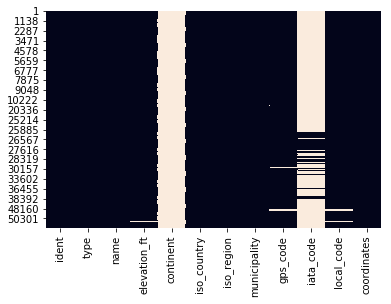

In [42]:
sns.heatmap(airport_df.isnull(), cbar=False)

In [43]:
airport_df.isnull().sum()

ident               0
type                0
name                0
elevation_ft       63
continent       14582
iso_country         0
iso_region          0
municipality       50
gps_code          399
iata_code       12717
local_code        199
coordinates         0
dtype: int64

In [33]:
# possible approach on how to eliminate null values
airport_df = airport_df[~airport_df['municipality'].isna()]

In [34]:
# possible approach to be applied in next section to make municipalities upper case
airport_df['municipality'] = airport_df.municipality.str.upper()

Identifying non standard entries in the iso_region field.

In [35]:
airport_df.iso_region.value_counts().tail()

US-DE     36
US-HI     35
US-RI     10
US-U-A     3
US-DC      2
Name: iso_region, dtype: int64

In [36]:
# possible approach in addressing the US-U-A value n the iso_region field
airport_df['iso_region_length'] = airport_df["iso_region"].apply(len)
airport_df = airport_df[airport_df['iso_region_length']==5]
airport_df['state'] = airport_df['iso_region'].str[-2:]
airport_df.drop(['iso_region_length'],axis=1,inplace=True)

In [37]:
airport_df.head(3)

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates,state
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,LEOTI,00AA,NaN,00AA,"-101.473911, 38.704022",KS
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,ANCHOR POINT,00AK,NaN,00AK,"-151.695999146, 59.94919968",AK
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,HARVEST,00AL,NaN,00AL,"-86.77030181884766, 34.86479949951172",AL


#### Demographic Data

In [49]:
print(f'The demographic data set contains {demographic_df.shape[0]} rows and {temperature_df.shape[1]} columns')

The demographic data set contains 2891 rows and 8 columns


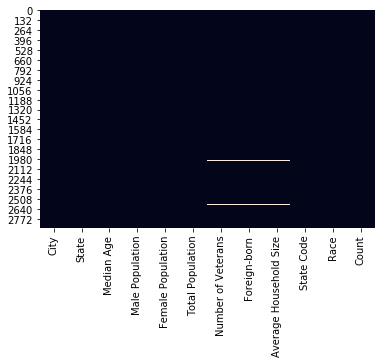

In [50]:
sns.heatmap(demographic_df.isnull(), cbar=False)

In [51]:
demographic_df.isnull().sum()

City                       0
State                      0
Median Age                 0
Male Population            3
Female Population          3
Total Population           0
Number of Veterans        13
Foreign-born              13
Average Household Size    16
State Code                 0
Race                       0
Count                      0
dtype: int64

Since the amount of missing data is not significant, we will focus on formatting some of the columns such as City.

In [38]:
# possible approach to make city names upper case for next section
demographic_df['City'] = demographic_df['City'].str.strip().str.upper()

In [39]:
demographic_df.head()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,SILVER SPRING,Maryland,33.8,40601.0,41862.0,82463,1562.0,30908.0,2.60,MD,Hispanic or Latino,25924
1,QUINCY,Massachusetts,41.0,44129.0,49500.0,93629,4147.0,32935.0,2.39,MA,White,58723
2,HOOVER,Alabama,38.5,38040.0,46799.0,84839,4819.0,8229.0,2.58,AL,Asian,4759
3,RANCHO CUCAMONGA,California,34.5,88127.0,87105.0,175232,5821.0,33878.0,3.18,CA,Black or African-American,24437
4,NEWARK,New Jersey,34.6,138040.0,143873.0,281913,5829.0,86253.0,2.73,NJ,White,76402


In [40]:
duplicated_rows = len(demographic_df[demographic_df[['City', 'State','Race']].duplicated()])

In [41]:
print(f'The number of duplicate rows when using a combined primary key with City,State, and Race is {duplicated_rows} rows, which means that this combined primary key can be used.')

The number of duplicate rows when using a combined primary key with City,State, and Race is 0 rows, which means that this combined primary key can be used.


#### Immigration Data (full dataset)

Briefly exploring the full immigration dataset, and performing some data cleaning actions.

In [42]:
pd.set_option('max_columns', None)
df_spark.limit(3).toPandas().head()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,i94bir,i94visa,count,dtadfile,visapost,occup,entdepa,entdepd,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,6.0,2016.0,4.0,692.0,692.0,XXX,20573.0,NaN,None,NaN,37.0,2.0,1.0,None,None,None,T,None,U,None,1979.0,10282016,None,None,None,1.897628e+09,None,B2
1,7.0,2016.0,4.0,254.0,276.0,ATL,20551.0,1.0,AL,NaN,25.0,3.0,1.0,20130811,SEO,None,G,None,Y,None,1991.0,D/S,M,None,None,3.736796e+09,00296,F1
2,15.0,2016.0,4.0,101.0,101.0,WAS,20545.0,1.0,MI,20691.0,55.0,2.0,1.0,20160401,None,None,T,O,None,M,1961.0,09302016,M,None,OS,6.666432e+08,93,B2


In [43]:
df_spark.createOrReplaceTempView('immigration_tbl')

In [60]:
df_spark.count()

3096313

In [61]:
spark.sql("""
SELECT COUNT (DISTINCT cicid)
FROM immigration_tbl
""").toPandas().head()

,count(DISTINCT cicid)
0,3096313


<i> Is cicid a unique identifier to be used as a primary key? </i>

In [62]:
df_spark.count() == spark.sql("""
SELECT COUNT (DISTINCT cicid)
FROM immigration_tbl
""").toPandas().head()

,count(DISTINCT cicid)
0,True


In [65]:
spark.sql("""
SELECT LENGTH (i94port) AS len
FROM immigration_tbl
GROUP BY len
""").toPandas().head()

,len
0,3


Visualizing some of the i94port codes for inconsistency

In [66]:
spark.sql("""
SELECT i94port,Count(i94port) as COUNT
FROM immigration_tbl
group by i94port
order by i94port DESC
LIMIT 10
""").toPandas()

,i94port,COUNT
0,YSL,344
1,YIP,1
2,YHC,772
3,YGF,1763
4,XXX,3522
5,X96,2378
6,X44,11
7,WPB,9093
8,WLL,14
9,WIN,330


In [44]:
#Computing the arrival date from the SAS starting from 1960-01-01
df_spark = spark.sql("SELECT *, date_add(to_date('1960-01-01'), arrdate) AS arrival_date FROM immigration_tbl")
df_spark.createOrReplaceTempView("immigration_tbl")

In [45]:
#Replacing I94VISA column values with (1=Business, 2=Pleasure,3=Student)

spark.sql("""SELECT *, CASE 
                        WHEN i94visa = 1.0 THEN 'Business' 
                        WHEN i94visa = 2.0 THEN 'Pleasure'
                        WHEN i94visa = 3.0 THEN 'Student'
                        ELSE 'N/A' END AS visa_type 
                        
                FROM immigration_tbl""").createOrReplaceTempView("immigration_tbl")

In [46]:
# Replacing N/A values
spark.sql("""SELECT *, CASE 
                        WHEN depdate >= 1.0 THEN date_add(to_date('1960-01-01'), depdate)
                        WHEN depdate IS NULL THEN NULL
                        ELSE 'N/A' END AS departure_date 
                        
                FROM immigration_tbl""").createOrReplaceTempView("immigration_tbl")

<i> Ensuring the feasibiity of previous queries</i>

In [61]:
spark.sql("SELECT count(*) FROM immigration_tbl WHERE departure_date = 'N/A'").toPandas().head()

,count(1)
0,0


In [66]:
spark.sql("""
SELECT COUNT(*)
FROM immigration_tbl
WHERE departure_date <= arrival_date
""").toPandas().head()

,count(1)
0,375


In [62]:
# Dropping rows where deperature date is greater or equal than arrival date
spark.sql("""
SELECT *
FROM immigration_tbl
WHERE departure_date >= arrival_date
""").createOrReplaceTempView("immigration_tbl")

<i>Continuing data exploration and identifying possible approaches for data cleaning purposes</i>

In [68]:
# Determing arrival modes
spark.sql("""
SELECT i94mode, count(*)
FROM immigration_tbl
GROUP BY i94mode
""").toPandas().head()

,i94mode,count(1)
0,NaN,238
1,1.0,2871184
2,3.0,61572
3,2.0,17970
4,9.0,2517


In [47]:
# Dropping rows where arrival mode is not equal to 1 = 'Air'
spark.sql("""
SELECT *
FROM immigration_tbl
WHERE i94mode == 1.0
""").createOrReplaceTempView("immigration_tbl")

In [64]:
# Determing arrival modes
spark.sql("""
SELECT i94mode, count(*)
FROM immigration_tbl
GROUP BY i94mode
""").toPandas().head()

,i94mode,count(1)
0,1.0,2871184


In [65]:
# Checking missing values in age column
spark.sql("""
SELECT COUNT(*)
FROM immigration_tbl
WHERE i94bir IS NULL
""").toPandas()

,count(1)
0,42


In [76]:
spark.sql("SELECT MAX(biryear), MIN(biryear) FROM immigration_tbl WHERE biryear IS NOT NULL").toPandas()

,max(biryear),min(biryear)
0,2016.0,1916.0


In [77]:
df_spark.select('biryear').describe()


DataFrame[summary: string, biryear: string]

In [78]:
#checking missing values in biryear column
spark.sql("SELECT COUNT(biryear) FROM immigration_tbl WHERE biryear IS NULL").toPandas()

,count(biryear)
0,0


In [79]:
spark.sql("SELECT (2016-biryear)-i94bir AS difference, count(*) FROM immigration_tbl WHERE i94bir IS NOT NULL GROUP BY difference").show()

+----------+--------+
|difference|count(1)|
+----------+--------+
|       0.0| 2871142|
+----------+--------+



In [80]:
# Checking the gendder field values
spark.sql("""
SELECT gender, count(*) 
FROM immigration_tbl
GROUP BY gender
""").toPandas()

,gender,count(1)
0,F,1190456
1,None,405106
2,M,1274898
3,U,13
4,X,711


In [48]:
# dropping rows where gender is not identified with F or M
spark.sql("""SELECT * FROM immigration_tbl WHERE gender IN ('F', 'M')""").createOrReplaceTempView("immigration_tbl")

In [67]:
# Checking the gendder field values
spark.sql("""
SELECT gender, count(*) 
FROM immigration_tbl
GROUP BY gender
""").toPandas()

,gender,count(1)
0,F,1190456
1,M,1274898


<i>Checking for missing values in the i94cit,i94res, i94addr, visatype, occup.</i>

In [68]:
def missing_values_check(spark_ctxt, tables_to_check):
    """
    This function performs null value checks on specific columns of given tables received as parameters and raises a ValueError exception when null values are encountered.
    It receives the following parameters:
    spark_ctxt: spark context where the data quality check is to be performed
    tables_to_check: A dictionary containing (table, columns) pairs specifying for each table, which column is to be checked for null values.   
    """  
    for table in tables_to_check:
        print(f"Performing data quality check on table {table}...")
        for column in tables_to_check[table]:
            returnedVal = spark_ctxt.sql(f"""SELECT COUNT(*) as nbr FROM {table} WHERE {column} IS NULL""")
            if returnedVal.head()[0] > 0:
                print(f"Data quality check failed! Found {returnedVal.head()[0]} NULL values in {table} {column} column!")
            else:
                print(f"Table {table} - {column} passed.")

In [69]:
tables_to_check = { 'immigration_tbl' : ['i94cit','i94res', 'i94addr', 'visatype', 'occup']}
missing_values_check(spark, tables_to_check)

Performing data quality check on table immigration_tbl...
Table immigration_tbl - i94cit passed.
Table immigration_tbl - i94res passed.
Data quality check failed! Found 87458 NULL values in immigration_tbl i94addr column!
Table immigration_tbl - visatype passed.
Data quality check failed! Found 2459850 NULL values in immigration_tbl occup column!


Analyzing tables twith null values to decide whether trying to include them in the analysis.

In [94]:
spark.sql("""
SELECT occup, count(*) as COUNT
FROM immigration_tbl
GROUP BY occup
ORDER BY occup
""").show()

+-----+-------+
|occup|  COUNT|
+-----+-------+
| null|2459850|
|  ACH|     28|
|  ACN|      8|
|  ADM|    118|
|  AGR|     11|
|  ASP|     17|
|  AST|      1|
|  ATH|     18|
|  BIL|      6|
|  BUG|      1|
|  CAN|      2|
|  CEO|     53|
|  CHE|      1|
|  CLN|      1|
|  CMP|     42|
|  CNS|      8|
|  CPA|     28|
|  DDS|     15|
|  DVM|      2|
|  EAG|      9|
+-----+-------+
only showing top 20 rows



In [95]:
spark.sql("""
SELECT i94addr, count(*) as COUNT
FROM immigration_tbl
GROUP BY i94addr
ORDER BY i94addr
""").show()

+-------+-----+
|i94addr|COUNT|
+-------+-----+
|   null|87458|
|     ..|    3|
|     .C|    1|
|     .I|    1|
|     .N|    3|
|     .T|    4|
|      0|    7|
|     10|    1|
|     20|    1|
|     33|    1|
|     70|    1|
|     99|   15|
|     AA|  101|
|     AE|    7|
|     AK| 1121|
|     AL| 5963|
|     AN|   84|
|     AO|    1|
|     AP|    8|
|     AQ|    4|
+-------+-----+
only showing top 20 rows



The occup field and i94addr have large amount of data missing, and their values are coded in way that is not useful; thus,these column may  not be part of the data model.

In [89]:
spark.sql("""
SELECT visa_type, visatype, count(*)
FROM immigration_tbl
GROUP BY visa_type, visatype
ORDER BY visa_type, visatype
""").show()

+---------+--------+--------+
|visa_type|visatype|count(1)|
+---------+--------+--------+
| Business|      B1|  182161|
| Business|      E1|    3027|
| Business|      E2|   15153|
| Business|     GMB|     132|
| Business|       I|    2931|
| Business|      I1|     211|
| Business|      WB|  183877|
| Pleasure|      B2|  931439|
| Pleasure|      CP|   11607|
| Pleasure|     CPL|       8|
| Pleasure|     GMT|   79354|
| Pleasure|     SBP|       2|
| Pleasure|      WT| 1028526|
|  Student|      F1|   24597|
|  Student|      F2|    1622|
|  Student|      M1|     679|
|  Student|      M2|      28|
+---------+--------+--------+



In [49]:
df_spark = spark.sql("""SELECT * FROM immigration_tbl""")

### Step 3: Define the Data Model

In [ ]:
<div align= "justify">Schema on read refers to an innovative data analysis strategy in new data-handling tools and other more involved database technologies. In schema on read, data is applied to a plan or schema as it is pulled out of a stored location, rather than as it goes in. More and more these days, data is a shared asset among groups of people with differing roles and differing interests who want to get different insights from that data; this approach is especially beneficial When delaing with increasingly large volume of data such as the immigration dataset in this project. With schema-on-read data can be presented in a schema that is adapted best to the queries being issued rather than being limited by a one-size-fits-all schema.</div>

In [ ]:
<img align="left" src="DBdiagram.png" >

In [ ]:
#### 3.1 Conceptual Data Model

The fact table is immigration_fact, and includes the following fields:
    
* cicid
* citizenship_country
* residence_country
* city
* state
* arrival_date
* departure_date
* age
* visa_type
* detailed_visa_type

Dimension tables are time_dim, airport_dim, demographic_dim, temperature_dim, and includes the following fields:

**time_dim** (aggretate data by time)
* date 
* year 
* month 
* day 
* week
* weekday
* year_day

**airport_dim** (determines area flow of travellers)
* ident
* type 
* name, 
* elevation_ft 
* state
* municipality 
* iata_code

**demographic_dim** (travellers origin areas demographic)
* City 
* State 
* median_age 
* male_population 
* female_population 
* total population
* foreign_born 
* average_Household_Size 
* state_code
* Race 
* Count

**temperature_dim**: (temperature data)
* date 
* city
* average temperature 
* average temperature uncertainty 


#### 3.2 Mapping Out Data Pipelines

Most steps to clean the data have been described in section 2.
##### Data Extraction:
* Load all the datasets from CSV and SAS data files;

##### Data Transformation and Loading:

##### immigration_fact :
* Dropping rows where the mode of arrival is not air travel
* Dropping rows with incorrect gender data
* Converting arrival and departure dates
* Replacing country codes with string equivalents
* Replacing visa_type with character string
* Replacing port of entry with city and state
* Dropping non US port of entry rows
* Computing age in a new row using birth year and year of our current date
* Inserting into fact table
* Write to parquet

##### temperature_dim:
* Dropping all data for cities outside the US
* Droppingtemperature table, drop all data for dates before 1950 
* Converting city to upper case
* Computing the average temperature and uncertainty over date+city partitions
* Inserting into the temperature table
* Writing to parquet

##### time_dim:
* Extracting arrival dates from the immigration dataset;
* Extracting year, month, day, week and inserting it time_dim 
* Write to parquet

##### airport_dim:
* Removing non US airports
* Removing non usable port of entries such as <b>closed, heliport, seaplane_base, balloonport</b>
* Removing rows with  missing municipalities
* Converting municipalities to upper case
* Inserting into table
* Writing to parquet

##### demographic_dim:
* Converting city names to upper case
* Inserting into table
* Writing to parquet

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

In [50]:
spark_df_demographic = spark.read.format("csv").option("header","true").option("delimiter",";").load('us-cities-demographics.csv')

In [51]:
spark_df_demographic.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: string (nullable = true)
 |-- Male Population: string (nullable = true)
 |-- Female Population: string (nullable = true)
 |-- Total Population: string (nullable = true)
 |-- Number of Veterans: string (nullable = true)
 |-- Foreign-born: string (nullable = true)
 |-- Average Household Size: string (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: string (nullable = true)



In [52]:
spark.createDataFrame(demographic_df).printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Median Age: double (nullable = true)
 |-- Male Population: double (nullable = true)
 |-- Female Population: double (nullable = true)
 |-- Total Population: long (nullable = true)
 |-- Number of Veterans: double (nullable = true)
 |-- Foreign-born: double (nullable = true)
 |-- Average Household Size: double (nullable = true)
 |-- State Code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: long (nullable = true)



#### Staging data

In [53]:
# loading dictionaries
countryCodes_df = pd.read_csv('countries.csv')
i94portCodes_df = pd.read_csv('i94ports_coding.csv')

# loading CSV files into pandas dataframes
demographics_df = pd.read_csv('us-cities-demographics.csv', sep=';')
temperatures_df = pd.read_csv('../../data2/GlobalLandTemperaturesByCity.csv')

# loading SAS data
df_immigration=spark.read.parquet("sas_data")

In [54]:
#Converting dictionaries to Spark
spark_df_countryCodes = spark.createDataFrame(countryCodes_df)
spark_df_countryCodes .createOrReplaceTempView("countryCodes")

In [55]:
#removing null values entries
i94portCodes_df = i94portCodes_df[~i94portCodes_df['state'].isna()].copy()

In [56]:
# List of non US countries/territories
non_US = ['ARGENTINA',
 'BAHAMAS',
 'BERMUDA',
 'BRAZIL',
 'CANADA',
 'CAYMAN ISLAND',
 'COLOMBIA',
 'Canada',
 'ECUADOR',
 'EL SALVADOR',
 'ENGLAND',
 'ETHIOPIA',
 'GABON',
 'INDONESIA',
 'IRELAND',
 'ITALY',
 'JAPAN',
 'KENYA',
 'MEXICO',
 'MX',
 'NETH ANTILLES',
 'NETHERLANDS',
 'NEW GUINEA',
 'PANAMA',
 'PRC',
 'ROMANIA',
 'SEOUL KOREA',
 'SOUTH AFRICA',
 'THAILAND',
 'TURK & CAIMAN',
 'URUGUAY']

In [57]:
#Exluding non_US countries.
i94portCodes_df = i94portCodes_df[~i94portCodes_df['state'].isin(non_US)].copy()

In [58]:
spark_df_i94portCodes = spark.createDataFrame(i94portCodes_df)
spark_df_i94portCodes .createOrReplaceTempView("i94portCodes")

In [59]:
df_immigration.createOrReplaceTempView("immigration_table")

In [60]:
# Remove non air-travel entries  
spark.sql("""
SELECT *
FROM immigration_table
WHERE i94mode = 1
""").createOrReplaceTempView("immigration_table")

In [61]:
# dropping undifned gender rows
spark.sql("""SELECT * FROM immigration_table WHERE gender IN ('F', 'M')""").createOrReplaceTempView("immigration_table")

In [62]:
# converting  the arrival dates to_date
spark.sql("SELECT *, date_add(to_date('1960-01-01'), arrdate) AS arrival_date FROM immigration_table").createOrReplaceTempView("immigration_table")

In [63]:
# converting the departure dates
spark.sql("""SELECT *, CASE 
                        WHEN depdate >= 1.0 THEN date_add(to_date('1960-01-01'), depdate)
                        WHEN depdate IS NULL THEN NULL
                        ELSE 'N/A' END AS departure_date 
                        
                FROM immigration_table""").createOrReplaceTempView("immigration_table")

In [64]:
# dropping invalid country of citizenship codes
spark.sql("""
SELECT imd.*, cit.country AS citizenship_country
FROM immigration_table imd
INNER JOIN countryCodes cit
ON imd.i94cit = cit.code
""").createOrReplaceTempView("immigration_table")

In [65]:
# dropping invalid residence codes
spark.sql("""
SELECT imd.*, cit.country AS residence_country
FROM immigration_table imd
INNER JOIN countryCodes cit
ON imd.i94res = cit.code
""").createOrReplaceTempView("immigration_table")

In [66]:
# Casting visa codes
spark.sql("""SELECT *, CASE 
                        WHEN i94visa = 1.0 THEN 'Business' 
                        WHEN i94visa = 2.0 THEN 'Pleasure'
                        WHEN i94visa = 3.0 THEN 'Student'
                        ELSE 'N/A' END AS visa_type 
                        
                FROM immigration_table""").createOrReplaceTempView("immigration_table")

In [67]:
# Adding entry_port names and entry port states
spark.sql("""
SELECT imd.*, pc.location AS entry_port, pc.state AS entry_port_state
FROM immigration_table imd 
INNER JOIN i94portCodes pc
ON imd.i94port = pc.code
""").createOrReplaceTempView("immigration_table")

In [68]:
# Computing age
spark.sql("""
SELECT *, (2016-biryear) AS age 
FROM immigration_table
""").createOrReplaceTempView("immigration_table")

In [69]:
# Inserting fact table data into spark dataframe
immigration_fact = spark.sql("""
                        SELECT 
                            cicid, 
                            citizenship_country,
                            residence_country,
                            TRIM(UPPER (entry_port)) AS city,
                            TRIM(UPPER (entry_port_state)) AS state,
                            arrival_date,
                            departure_date,
                            age,
                            visa_type,
                            visatype AS detailed_visa_type

                        FROM immigration_table
""")

In [70]:
immigration_fact.show(2)

+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
|    cicid|citizenship_country|residence_country|  city|state|arrival_date|departure_date| age|visa_type|detailed_visa_type|
+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
|4041803.0|            GERMANY|          GERMANY|BANGOR|   ME|  2016-04-22|    2016-05-07|49.0| Business|                B1|
|4041804.0|            GERMANY|          GERMANY|BANGOR|   ME|  2016-04-22|          null|38.0| Business|                B1|
+---------+-------------------+-----------------+------+-----+------------+--------------+----+---------+------------------+
only showing top 2 rows



In [71]:
# extracting distinct dates from arrival and departure to create time_dim table
dim_time = spark.sql("""
SELECT DISTINCT arrival_date AS date
FROM immigration_table
UNION
SELECT DISTINCT departure_date AS date
FROM immigration_table
WHERE departure_date IS NOT NULL
""")
dim_time.createOrReplaceTempView("time_dim")

In [72]:
# Extracting year, month, day, weekofyear, dayofweek and weekofyear
time_dim = spark.sql("""
SELECT date, YEAR(date) AS year, MONTH(date) AS month, DAY(date) AS day, WEEKOFYEAR(date) AS week, DAYOFWEEK(date) as weekday, DAYOFYEAR(date) year_day
FROM time_dim
ORDER BY date ASC
""")

In [73]:
time_dim.show(2)

+----------+----+-----+---+----+-------+--------+
|      date|year|month|day|week|weekday|year_day|
+----------+----+-----+---+----+-------+--------+
|2012-04-12|2012|    4| 12|  15|      5|     103|
|2015-05-18|2015|    5| 18|  21|      2|     138|
+----------+----+-----+---+----+-------+--------+
only showing top 2 rows



In [74]:
# Excluding non US data
temperature_df = temperature_df[temperature_df['Country']=='United States'].copy()

# Converting date column to datetime objects
temperature_df['date'] = pd.to_datetime(temperature_df.dt)

# Removind datapoints before 1950
temperature_df= temperature_df[temperature_df['date']>"1950-01-01"].copy()

In [75]:
# Removing white space and converting to upper case
temperature_df['City'] = temperature_df['City'].str.strip().str.upper()

In [76]:
# converting to Spark
spark_df_temperature = spark.createDataFrame(temperature_df)
spark_df_temperature .createOrReplaceTempView("temperature")

In [77]:
temperature_dim = spark.sql("""
SELECT
    DISTINCT date, city,
    AVG(AverageTemperature) OVER (PARTITION BY date, City) AS average_temperature, 
    AVG(AverageTemperatureUncertainty)  OVER (PARTITION BY date, City) AS average_termperature_uncertainty
    
FROM temperature
""")

In [79]:
temperature_dim.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- city: string (nullable = true)
 |-- average_temperature: double (nullable = true)
 |-- average_termperature_uncertainty: double (nullable = true)



In [80]:
# Cleaning dempographic_df dataframe
demographic_df['City'] = demographic_df.City.str.strip().str.upper()
demographic_df['State Code'] = demographic_df['State Code'].str.strip().str.upper()
demographic_df.Race = demographic_df.Race.str.strip().str.upper()

In [81]:
# Converting to Spark
spark_df_demographics = spark.createDataFrame(demographic_df)
spark_df_demographics.createOrReplaceTempView("demographics")

In [82]:
# Inserting data into dempgraphic_dim
demographic_dim = spark.sql("""
                                SELECT  City, 
                                        State, 
                                        `Median Age` AS median_age, 
                                        `Male Population` AS male_population, 
                                        `Female Population` AS female_population, 
                                        `Total Population` AS total_population, 
                                        `Foreign-born` AS foreign_born, 
                                        `Average Household Size` AS average_household_size, 
                                        `State Code` AS state_code, 
                                        Race, 
                                        Count
                                FROM demographics
""")

In [83]:
demographic_dim.printSchema()

root
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- median_age: double (nullable = true)
 |-- male_population: double (nullable = true)
 |-- female_population: double (nullable = true)
 |-- total_population: long (nullable = true)
 |-- foreign_born: double (nullable = true)
 |-- average_household_size: double (nullable = true)
 |-- state_code: string (nullable = true)
 |-- Race: string (nullable = true)
 |-- Count: long (nullable = true)



In [84]:
#Loading airports data
spark_df_airports = spark.read.format("csv").option("header", "true").load('airport-codes_csv.csv')
spark_df_airports.createOrReplaceTempView("airports")

In [85]:
#Cleaning data
spark.sql("""
SELECT *
FROM airports
WHERE iso_country IS NOT NULL
AND UPPER(TRIM(iso_country)) LIKE 'US'
""").createOrReplaceTempView("airports")

In [86]:
# Cleaning data
spark.sql("""
SELECT *
FROM airports
WHERE LOWER(TRIM(type)) NOT IN ('closed', 'heliport', 'seaplane_base', 'balloonport')
AND municipality IS NOT NULL
AND LENGTH(iso_region) = 5
""").createOrReplaceTempView("airports")

In [87]:
airport_dim = spark.sql("""
SELECT TRIM(ident) AS ident, type, name, elevation_ft, SUBSTR(iso_region, 4) AS state, TRIM(UPPER(municipality)) AS municipality, iata_code
FROM airports
""")

In [88]:
airport_dim.printSchema()

root
 |-- ident: string (nullable = true)
 |-- type: string (nullable = true)
 |-- name: string (nullable = true)
 |-- elevation_ft: string (nullable = true)
 |-- state: string (nullable = true)
 |-- municipality: string (nullable = true)
 |-- iata_code: string (nullable = true)



In [89]:
airport_dim.show(2)

+-----+-------------+--------------------+------------+-----+------------+---------+
|ident|         type|                name|elevation_ft|state|municipality|iata_code|
+-----+-------------+--------------------+------------+-----+------------+---------+
| 00AA|small_airport|Aero B Ranch Airport|        3435|   KS|       LEOTI|     null|
| 00AK|small_airport|        Lowell Field|         450|   AK|ANCHOR POINT|     null|
+-----+-------------+--------------------+------------+-----+------------+---------+
only showing top 2 rows



In [ ]:
# Saving the data in parquet format
demographic_dim.write.parquet("demographic_dim")
time_dim.write.parquet("time_dim")
airport_dim.write.parquet("airport_dim")
temperature_dim.write.parquet("temperature_dim")
immigration_fact.write.parquet("immigration_fact")

#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

##### Performing two automated quality checks on missing values and number of rows.

In [130]:
# Loading data for data checks
demographic_dim.createOrReplaceTempView("demographic_dim")
time_dim.createOrReplaceTempView("time_dim")
airport_dim.createOrReplaceTempView("airport_dim")
temperature_dim.createOrReplaceTempView("temperature_dim")
immigration_fact.createOrReplaceTempView("immigration_fact")

In [131]:
def null_check(spark_c, table):
    """
    Function performs null vchecks on columns received as parameters and raises a ValueError exception when null values are encountered.
    Parameters:
    spark: where the data quality check is to be performed
    tables_to_check: A dictionary containing (table, columns) pairs specifying for each table, which column is to be checked for null values.   
    """  
    for table in tables_to_check:
        print(f"Performing data quality check on table {table}...")
        for column in tables_to_check[table]:
            returnedVal = spark_c.sql(f"""SELECT COUNT(*) as nbr FROM {table} WHERE {column} IS NULL""")
            if returnedVal.head()[0] > 0:
                raise ValueError(f"Data quality check failed! Found NULL values in {column} column!")
        print(f"Table {table} passed.")

In [132]:
#dictionary of tables and columns to be checked
tables_to_check = { 'immigration_fact' : ['cicid'], 'time_dim':['date'], 'demographic_dim': ['City','state_code'], 'airport_dim':['ident'], 'temperature_dim':['date','City']}

#We call our function on the spark context
null_check(spark, tables_to_check)

Performing data quality check on table immigration_fact...
Table immigration_fact passed.
Performing data quality check on table time_dim...
Table time_dim passed.
Performing data quality check on table demographic_dim...
Table demographic_dim passed.
Performing data quality check on table airport_dim...
Table airport_dim passed.
Performing data quality check on table temperature_dim...
Table temperature_dim passed.


In [146]:
def number_of_rows_check(spark_ctxt, tables_to_check):
    """
    This function performs a check on number of rows of given tables to ensure it matches what is expected.
    It receives the following parameters:
    spark_ctxt: spark context where the data quality check is to be performed
    tables_to_check: A dictionary containing (table, expected row counts) 
    """  
    for table in tables_to_check:
        print(f"Performing data quality check on table {table}...")
        for column in tables_to_check[table]:
            returnedVal = spark_ctxt.sql(f"""SELECT COUNT(*) - {column} as nbr FROM {table} """)
            if returnedVal.head()[0] > 0:
                print(f"Data quality check failed for {table}!")
            else:
                print(f"Table {table} passed number of rows quality check.")

In [154]:
tables_to_check = { 'time_dim' : [192],'airport_dim':[14529],'temperature_dim':[189472],'demographic_dim':[2891]}

In [155]:
number_of_rows_check(spark,tables_to_check)

Performing data quality check on table time_dim...
Table time_dim passed number of rows quality check.
Performing data quality check on table airport_dim...
Table airport_dim passed number of rows quality check.
Performing data quality check on table temperature_dim...
Table temperature_dim passed number of rows quality check.
Performing data quality check on table demographic_dim...
Table demographic_dim passed number of rows quality check.


Completing more manual quality checks

In [158]:
# checking  distinct date key 
spark.sql("""
SELECT COUNT(DISTINCT date) - 192
FROM time_dim
""").show()

+--------------------------------------------+
|(count(DISTINCT date) - CAST(192 AS BIGINT))|
+--------------------------------------------+
|                                           0|
+--------------------------------------------+



In [159]:
# checking fact table and time_dim to ensure all dates match
spark.sql("""
SELECT DISTINCT date
FROM time_dim

MINUS

(SELECT DISTINCT arrival_date AS date
FROM immigration_table
UNION
SELECT DISTINCT departure_date AS date
FROM immigration_table
WHERE departure_date IS NOT NULL)

""").show()

+----+
|date|
+----+
+----+



In [160]:
#checking distinct counts
spark.sql("""
SELECT count(distinct cicid) - 2165257
FROM immigration_table
""").show()

+-------------------------------------------------+
|(count(DISTINCT cicid) - CAST(2165257 AS BIGINT))|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+



In [161]:
spark.sql("""
SELECT count(distinct cicid) - 2165257
FROM immigration_fact
""").show()

+-------------------------------------------------+
|(count(DISTINCT cicid) - CAST(2165257 AS BIGINT))|
+-------------------------------------------------+
|                                                0|
+-------------------------------------------------+



In [162]:
spark.sql("""
SELECT count(*) - 2165257
FROM immigration_fact
""").show()



+------------------------------------+
|(count(1) - CAST(2165257 AS BIGINT))|
+------------------------------------+
|                                   0|
+------------------------------------+



In [163]:
# Checking demographics dimension table  
spark.sql("""
SELECT COUNT(DISTINCT city, state, race) - 2891
FROM demographic_dim
""").show()


+----------------------------------------------------------+
|(count(DISTINCT city, state, race) - CAST(2891 AS BIGINT))|
+----------------------------------------------------------+
|                                                         0|
+----------------------------------------------------------+



In [164]:
spark.sql("""
SELECT COUNT(DISTINCT ident) - 14529
FROM airport_dim
""").show()


+-----------------------------------------------+
|(count(DISTINCT ident) - CAST(14529 AS BIGINT))|
+-----------------------------------------------+
|                                              0|
+-----------------------------------------------+



In [165]:
spark.sql("""
SELECT COUNT(DISTINCT date, city) - 189472
FROM temperature_dim
""").show()



+-----------------------------------------------------+
|(count(DISTINCT date, city) - CAST(189472 AS BIGINT))|
+-----------------------------------------------------+
|                                                    0|
+-----------------------------------------------------+



Checking the distinct number of pair couple (city/state) in the fact table

In [166]:
spark.sql("""
SELECT COUNT(DISTINCT city, state)
FROM immigration_fact
""").toPandas()

,"count(DISTINCT city, state)"
0,151


Checking the distinct number of pair couple (city/state) that are present in immigration_fact and airport_dim

In [167]:
spark.sql("""
SELECT COUNT(*)
FROM
(
SELECT DISTINCT city, state
FROM immigration_fact
) fi
INNER JOIN 
(
SELECT DISTINCT municipality, state
FROM airport_dim
) da
ON fi.city = da.municipality
AND fi.state = da.state
""").toPandas().head()

,count(1)
0,102


Checking the distinct number of pair couple (city/state) that are present in immigration_fact and demographic_dim

In [168]:
spark.sql("""
SELECT COUNT(*)
FROM
(
SELECT DISTINCT city, state
FROM immigration_fact
) ift
INNER JOIN 
(
SELECT DISTINCT City, state_code
FROM demographic_dim
) ddt
ON ift.city = ddt.City
AND ift.state = ddt.state_code
""").show(2)

+--------+
|count(1)|
+--------+
|      69|
+--------+



After running the pair couple comparison we observe the following:
* 66% of immigration data can be paired with airport data
* 46% of immigration data can be paired with demographic data

#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

#### Step 5: Complete Project Write Up
<div style="text-align: justify"> 
The immigration dataset has three million rows just for one month worth of observations, and combined with other data sets can lead to a significant amount of data especialy over a long period of time. Spark's ability to reduce the number of read/write cycle to disk and storing intermediate data in-memory allows to rapidily run repetead queries, making a great choice for the capstone project.  </div>

***



***

<div style ="text-align: justify">The objective listed in the beginnig section of the project can all be achieved. In fact, the underlying data would most likely need to be updated once every three months or to a larger pridic time frame. In addition, Apache Spark can process data from a variety of data repositories, including the Hadoop Distributed File System (HDFS), NoSQL databases and relational data stores. The only limitation could come from the hardware configuration of the Big Data cluster or device lacks physical memory (RAM) as Spark engine heavily relies on good amounts of RAM on the relevant nodes for in-memory processing.</div>

#### Alternate requirement scenarios:

How would our approach change if the problem had the following requireements:
* The database needed to be accessed by 100+ people: Once the data is ready to be consumed, it would be stored in a AWS redshift cluster supporting secure access for multiple users. 
* The data was increased by 100x: Data would be stored in an Amazon Storage Service (S3) or its alternative such as Azure Blob Storage, Google Cloud Storage, DigitalOcean Spaces, and Zadara. We would contiue using Spark as it is best suited for handling Big Data.
* The data populates a dashboard that must be updated on a daily basis by 7am every day: To support a dynamic dashboard we could use Apache Airflow to perform the ETL/data quality validation as well as Airflow scheduler capability to ensure it updates daily.


#### Aknowledgment

* Chapeau to StackOverflow, GitHub, and Udacity Knowledge platforms for providing some guidance code.

